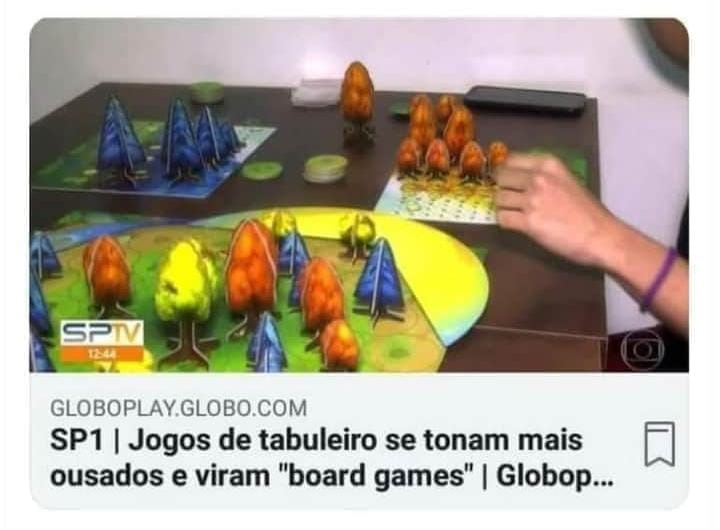

In [2]:
# !virtualenv venv --python=python3
# !source venv/bin/activate
# !pip install numpy pandas
# Se necessário instalar o jupyter dentro do ambiente virtual:
# !pip install jupyter

# Uma análise sobre a maior comunidade de Board Games do mundo (BoardGameGeek)
### Por Rômulo Filho 

Como muito bem exemplificou o  **SP TV** da Rede Globo, nos últimos anos os jogos de tabuleiro tem se diversificado tanto em variedade de temas quanto em complexidade de sistemas. Dos tradicionais **Jogo da Vida** e **Banco Imobiliário** passando por já clássicos como **Catan** e **Carcassone** até chegar a jogos extremamente complexos com partidas que podem durar dias.

Com um universo de possibilidades que cresce mais a cada dia, os "Boardgamers" se organizaram em comunidades tanto locais ao redor de luderias quanto online, no Brasil a mais famosa é a Ludopedia, que segue o formato do BoardGameGeek (BGG). Este último é a maior rede social de jogos de tabuleiro do mundo.

Dessa forma, busco com este trabalho analisar um conjunto de dados do BGG disponível no [Kaggle](https://www.kaggle.com/gabrio/board-games-dataset) e responder as seguintes perguntas:
- Quem são os jogadores?
- O que define um bom jogo de tabuleiro?
- Existe uma quantidade ideal de jogadores que influencie na nota?
- A duração de uma partida influencia na nota?
- Qual a influência da dificuldade na nota?

In [2]:
import sqlite3

import numpy as np
import pandas as pd

In [12]:
db_sql = sqlite3.connect('database.sqlite')

df = pd.read_sql_query("SELECT * FROM BoardGames", db_sql)
# print(df.head())
print(df.shape)
db_sql.close()

(90400, 81)


In [4]:
df

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,...,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,boardgame,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4.0,30.0,12.0,3.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,boardgame,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4.0,60.0,10.0,2.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,boardgame,When you see the triangular box and the luxuri...,//cf.geekdo-images.com/images/pic285299.jpg,4.0,60.0,12.0,2.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,boardgame,"In Acquire, each player strategically invests ...",//cf.geekdo-images.com/images/pic342163.jpg,6.0,90.0,12.0,3.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90395,90396,220053,boardgame,Soldier Ball is a tabletop skill and strategy ...,//cf.geekdo-images.com/images/pic3436079.jpg,2.0,15.0,4.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90396,90397,220055,boardgame,Description from the designer:&#10;&#10;The ye...,//cf.geekdo-images.com/images/pic3529002.jpg,4.0,45.0,14.0,2.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90397,90398,220068,boardgameexpansion,Cecrops founded Athens and judged a competitio...,//cf.geekdo-images.com/images/pic3503602.jpg,4.0,90.0,14.0,1.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90398,90399,220069,boardgameexpansion,"The famous Myrmidons are the army of Achilles,...",//cf.geekdo-images.com/images/pic3437871.jpg,4.0,90.0,14.0,1.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cols = df.columns.tolist()
for col in cols: print(col)
# per_designer = df.groupby("attributes.boardgamedesigner")

# games = df["details.name"]


row_names
game.id
game.type
details.description
details.image
details.maxplayers
details.maxplaytime
details.minage
details.minplayers
details.minplaytime
details.name
details.playingtime
details.thumbnail
details.yearpublished
attributes.boardgameartist
attributes.boardgamecategory
attributes.boardgamecompilation
attributes.boardgamedesigner
attributes.boardgameexpansion
attributes.boardgamefamily
attributes.boardgameimplementation
attributes.boardgameintegration
attributes.boardgamemechanic
attributes.boardgamepublisher
attributes.total
stats.average
stats.averageweight
stats.bayesaverage
stats.family.abstracts.bayesaverage
stats.family.abstracts.pos
stats.family.cgs.bayesaverage
stats.family.cgs.pos
stats.family.childrensgames.bayesaverage
stats.family.childrensgames.pos
stats.family.familygames.bayesaverage
stats.family.familygames.pos
stats.family.partygames.bayesaverage
stats.family.partygames.pos
stats.family.strategygames.bayesaverage
stats.family.strategygames.pos
stats.family

### Pré-processamento

In [13]:
# Removendo expansões
print(df['game.type'].unique(), df.shape)
df = df[df['game.type']=='boardgame']
print(df['game.type'].unique(), df.shape)
# Como vemos no segundo print as expansões foram removidas

['boardgame' 'boardgameexpansion'] (90400, 81)
['boardgame'] (76688, 81)


In [14]:
# Removendo colunas indesejadas
# cols = df.columns.tolist()
# unwanted = []
for col in df:
    if 'polls' in col or 'family' in col or 'subtype' in col:
        df.drop(col, axis=1, inplace=True)
        
df.drop('details.description', axis=1, inplace=True)
df.drop('details.image', axis=1, inplace=True)
df

,row_names,game.id,game.type,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,...,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing,attributes.t.links.concat.2....
0,1,1,boardgame,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,...,0.0,1763.0,719.0,5251.0,1.59321,170.0,4498.0,505.0,1654.0,None
1,2,2,boardgame,4.0,30.0,12.0,3.0,30.0,Dragonmaster,30.0,...,0.0,273.0,52.0,1053.0,1.46282,73.0,478.0,67.0,161.0,None
2,3,3,boardgame,4.0,60.0,10.0,2.0,30.0,Samurai,60.0,...,0.0,3281.0,1355.0,11870.0,1.18531,234.0,12019.0,707.0,2601.0,None
3,4,4,boardgame,4.0,60.0,12.0,2.0,60.0,Tal der Könige,60.0,...,0.0,111.0,30.0,523.0,1.21028,29.0,314.0,61.0,112.0,None
4,5,5,boardgame,6.0,90.0,12.0,3.0,90.0,Acquire,90.0,...,0.0,5011.0,1515.0,18682.0,1.33020,823.0,15195.0,516.0,2219.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90393,90394,220037,boardgame,4.0,0.0,0.0,2.0,0.0,Flight Round the World,0.0,...,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,None
90394,90395,220051,boardgame,4.0,120.0,12.0,3.0,60.0,The JRPG Tabletop Adventure Game,120.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.0,None
90395,90396,220053,boardgame,2.0,15.0,4.0,2.0,5.0,Soldier Ball,15.0,...,0.0,3.0,1.0,3.0,0.00000,0.0,3.0,0.0,0.0,None
90396,90397,220055,boardgame,4.0,45.0,14.0,2.0,30.0,Habeamus,45.0,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,None
